# Image Processing with Convolutions

In image processing, most image filters and image transformation use convolutions. Convolutions modify the original matrix of pixels through a pointwise multiplication with a kernel or filter matrix. Wikipedia describes <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)">convolutions on images</a> as:

> Convolution is the process of multiplying each element of the image with its local neighbors, weighted by the kernel. For example, if we have two three-by-three matrices, one a kernel, and the other an image piece, convolution is the process of flipping both the rows and columns of the kernel and then multiplying locationally similar entries and summing. The [2,2] element of the resulting image would be a weighted combination of all the entries of the image matrix, with weights given by the kernel: 

> ![Image of convolution](https://wikimedia.org/api/rest_v1/media/math/render/svg/1a5bdd585d515770c888ea5b4ea07a7a5166cc8d)

Amongst the suite of applications of convolutions, image blurring and sharpening as well as edge detection are the most common. In this demo, we will use MLDB query to transform efficiently transform images. To do so, we will use the [MNIST database of handwriten digits](http://yann.lecun.com/exdb/mnist/).

In this demo, we will use a custom function type called [SQL Expression Function](../../../../doc/#builtin/functions/SqlExpressionFunction.md.html) and [jseval](../../../../doc/#builtin/sql/ValueExpression.md.html) for inline definition of functions using Javascript.

The notebook cells below use `pymldb`'s `Connection` class to make [REST API](../../../../doc/#builtin/WorkingWithRest.md.html) calls. You can check out the [Using `pymldb` Tutorial](../../../../doc/nblink.html#_tutorials/Using pymldb Tutorial) for more details.

In [61]:
from pymldb import Connection
mldb = Connection(host = "http://127.0.0.1:11700/")

... And other Python librairies

In [62]:
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Latex
from ipywidgets import widgets, interact

## Loading the data

A pickled version of the dataset is available on the deeplearning.net website http://deeplearning.net/tutorial/gettingstarted.html.

The dataset has been unpickled and saved in a public Amazon's S3 cloud storage. Check out MLDB's [Protocol Handlers](../../../../doc/#builtin/Url.md.html) for Files and URLS.

In [63]:
data_url_mnist = 'http://public.mldb.ai.s3.amazonaws.com/datasets/digits_data.csv.gz'

print mldb.put('/v1/procedures/import_digits_mnist', {
    "type":"import.text",
    "params": {
        "dataFileUrl": data_url_mnist,
        "outputDataset": "digits_mnist",
        "select": "{* EXCLUDING(\"785\")} AS *, \"785\" AS label",
        "runOnCreation": True,
    }
})

<Response [201]>


## Taking a random image and starting image manipulation

Similarly to first few steps in the [Real-Time Digits Recognizer](../../../../ipy/notebooks/_tutorials/v2016.06.22.dev-5d85bf1/Real-Time%20Digits%20Recognizer.ipynb) demo, we will display random MNIST digits from the test set.

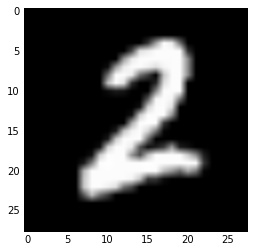

In [64]:
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
no_test_img = mldb.query("SELECT count({label}) FROM digits_mnist WHERE rowHash() % 5 = 0").values[0][0]

offset = random.randint(0, int(no_test_img/len(labels)))
digit = random.choice(labels)

data = mldb.query("""
    SELECT 
        * EXCLUDING(label)
    FROM digits_mnist
    WHERE label = %(digit)d AND rowHash() %% 5 = 0
    LIMIT 1
    OFFSET %(offset)d
""" % {"digit": digit, "offset": offset})


image = data.as_matrix().reshape(28, 28)
plt.imshow(image)
plt.gray()

## Defining the convolution function

A discrete convolution can be defined mathematically as:

$newPixel[i,j] = \sum_{y=i}^{i+r}\sum_{x=j}^{j+r}oldPixel[x,y] \cdot weight[x,y]$

where the $weight[]$ matrix (see 'kernelDict' dictionary in a couple of cells below) defines the type of image manipulation and $r$ is the area of effect.

In [65]:
# JavaScript code loosely based on Ivan Kuckir's blog post: http://blog.ivank.net/fastest-gaussian-blur.html

def create_convolution():
    
    JsConvolutionExpr = """
        jseval('
            var row_val = val;
            var dim = Math.sqrt(row_val.length);
            var radius = Math.sqrt(kernel.length);
            var alpha = alpha_;
            
            
            /*************************************
            ******** Function Definition *********
            **************************************/

            // input 1D list, output 1D list, pixel matrix dimensions
            function convolution(inList, outList, width, height, alpha, radius) {

                for (var i = 0; i < height; i++)
                    for (var j = 0; j < width; j++) {
                        var newPixel = 0;
                        var indexW = 0;
                        
                        for (var yr = i; yr < i + radius; yr++)
                            for (var xr = j; xr < j + radius; xr++) {
                            
                              var y = Math.min(height - 1, Math.max(0, yr));
                              var x = Math.min(width - 1, Math.max(0, xr));
                              
                              newPixel = newPixel + inList[y * width + x] * weights[indexW];
                              indexW ++;
                            }
                            
                        new_value = newPixel * alpha;
                        outList[i * width + j] = new_value;
                    }
                return outList;
            } // End of convolution
            
            //Assuring that the 1d row is in the right order
            function arrangeMatrix(inList) {
            
                var length = inList.length;
                var data = new Array(length);
                for (var i = 0; i < length; i++) {
                    data[parseInt(inList[i][0][0])] = inList[i][1];
                }
                return data
            }
            
            /*************************************
            ********** Using Functions ***********
            **************************************/
            
            var weights = arrangeMatrix(kernel); // filter matrix
            var matrix = arrangeMatrix(row_val); // my picture
            var convolvedMatrix = [];
            
            convolution(matrix, convolvedMatrix, dim, dim, alpha, radius);

            return convolvedMatrix;',
            'val, alpha_, kernel', 
             valueExpr, alpha, kernel
        ) AS *
    """


    print mldb.put("/v1/functions/convolution", {
        "type": "sql.expression",
        "params": {
            "expression": JsConvolutionExpr,
            "prepared": True
        }
    })
    
create_convolution()

<Response [201]>


As seen in the code above, each new pixel in the convolved picture is the weighted sum of the the pixel and its neighboring pixels where the weights are the values in the kernel matrix.  

Doing convolutions with custom function type called [SQL Expression Function](../../../../doc/#builtin/functions/SqlExpressionFunction.md.html) and [jseval](../../../../doc/#builtin/sql/ValueExpression.md.html) for inline definition of functions using Javascript allows us to process large amounts of data using the optimizations inherent to the MLDB platform. Convolutions are typically very time consuming operations with 
$O(n.r^2)$ complexity in this case where n is the number of features and r is the radius (i.e. neighboring pixels).

There were two steps to creating the function above:
* JsConvolutionExpr used a jseval built-in function where all the logic resides
* A 'convolution' SQL Expression Function is created, allowing us to call 'convolution' with a simple [mldb.query](../../../../doc/#builtin/sql/Sql.md.html)

## Using the convolution function

In [66]:
def convolutionFunc(image_processing):
    
    alpha = 1
    
    kernelDict = {
        'Right Sobel': [-1, 0, 1, -2, 0, 2, -1, 0, 1], 
        'Detect Edges': [1, 1, 1, 1, -8, 1, 1, 1, 1],
        'Sharpen': [0, -1, 0, -1, 5, -1, 0, -1, 0],
        'Box Blur': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        'Approximated Gaussian Blur': [0.0625, 0.125, 0.0625, 0.125, 0.25, 0.125, 0.0625, 0.125, 0.0625]
    }
    
    SQL_Expr = """
        SELECT convolution({
                valueExpr: %(data)s,
                alpha: %(alpha)d,
                kernel: %(kernel)s
        }) AS *
    """ %   {
                "alpha": alpha,
                "data": data.values[0].tolist(),
                "kernel": kernelDict[image_processing]
            }

    convolvedData = mldb.query(SQL_Expr)

    image = convolvedData.as_matrix().reshape(28, 28)
    plt.imshow(image)

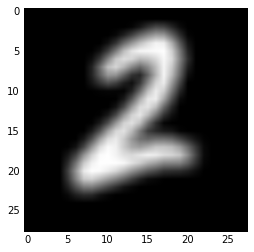

In [67]:
options=('Right Sobel', 'Detect Edges', 'Sharpen', 'Box Blur', 'Approximated Gaussian Blur')

# Creating an interactive dropdown menu
interact(convolutionFunc, image_processing=options, );
print "Choose an image processing option from the drop-down menu"

I found the 'Detect Edges' convolution particularly useful when training image recognition models. This can be useful in many Machine Vision applications.

## Where to next?

If you are interested in building your own custom image manipulation algorithms, you can click [here](../../../../ipy/notebooks/_demos/Convolutions%20using%20SQL%20and%20javascript.ipynb) to jump to the Convolution Demo. Otherwise, check out the other [Tutorials and Demos](../../../../doc/#builtin/Demos.md.html).